<a href="https://colab.research.google.com/github/premonish/YOUNGER_deprecated/blob/main/YOUNGER_Age_Estimator_PREPROCESS_MODEL_042121_2221.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **YOUNGER - Age Estimator**

# **IV. PREPROCESSING**

## **4 Pre-Processing and Training Data**
* 4.1 Contents
* 4.2 Introduction
* 4.3 Imports
* 4.4 Load Data
* 4.5 Verify Data
* 4.6 Train/Test Split
* 4.7 Simple Model
 * 4.7.1 Metrics
* 4.8 Initial Models
 * 4.8.1 Scale the data
 * 4.8.2 Train the model on the train split
 * 4.8.3 Make predictions using the model on both train and test splits
 * 4.8.4 Assess model performance
 * 4.8.5 Scale the data
 * 4.8.6 Train the model on the train split
 * 4.8.7 Make predictions using the model on both train and test splits
 * 4.8.8 Assess model performance
 * 4.8.9 Pipelines
   * 4.8.9.1 Define the pipeline
   * 4.8.9.2 Fit the pipeline
   * 4.8.9.3 Make predictions on the train and test sets
   * 4.8.9.4 Assess performance
* 4.9 Refining The Linear Model
 * 4.9.1 Define the pipeline
 * 4.9.2 Fit the pipeline
 * 4.9.3 Assess performance on the train and test set
 * 4.9.4 Define a new pipeline to select a different number of features
 * 4.9.5 Fit the pipeline
 * 4.9.6 Assess performance on train and test data
 * 4.9.7 Assessing performance using cross-validation
 * 4.9.8 Hyperparameter search using GridSearchCV
* 4.10 Random Forest Model
 * 4.10.1 Define the pipeline
 * 4.10.2 Fit and assess performance using cross-validation
 * 4.10.3 Hyperparameter search using GridSearchCV
* 4.11 Final Model Selection
 * 4.11.1 Linear regression model performance
 * 4.11.2 Random forest regression model performance
 * 4.11.3 Conclusion
* 4.12 Data quantity assessment
* 4.13 Save best model object from pipeline
* 4.14 Summary


---



##**4.2 Introduction**

Previously, to create an age-predictor, we have completed a notebook import data and explore its attributes: [Data Wrangling & Exploratory Data Analysis](https://github.com/premonish/YOUNGER/blob/main/notebooks/YOUNGER_Age_Estimator_WRANGLING_EDA_v2.ipynb). We took a close look at the metadata and plotted some histograms of the variable distributions. We transformed the data to extract the age of the primary face in each image from their date-of-birth and the date the photo was taken. We focused on extracting a large array of vectors of the pixel information per photo. We finished the previous phase by creating 2 arrays: 'matrix_x' containing the (150,000+ pixel/image) data from each image in the dataset, and 'vector_y' containing the corresponding 'age' labels for the images. 

In this notebook, we will focus on Preprocessing & Modeling. In particular, we will use a Convolutional Neural Network, which is industry standard for Machine Learning image classification tasks due to its unmatched performance.  


---



**Historical Context** 
>
> Image classification has been around for decades, however the field has been rapidly maturing in the last decade.  Since 2010, [ImageNet](https://https://en.wikipedia.org/wiki/ImageNet) Large Scale Visual Recognition Challenge (ILSVRC) is an annual competition where teams attempt to categorize thousands of images into 1,000 classes. In 2012, 'AlexNet' won the competition by a landslide and this is considered a pivotal moment in the history of deep learning, enabled by ingenious data scientists, a massive labeled dataset, and GPUs for training.




**PREPROCESSING** will be focused on three main sections.

1. Create Dummy Variables for categorical variables where appropriate.
2. Standardize the magnitude of numeric features using a scaler.
3. Split data into testing and training datasets.

**MODELING** will focus on the following four phases.
1. Train the models on the dataset (fit)
2. Review model performance metrics
3. Iterate over other models
4. Identify the final model  


---



## **4.3 Imports**

In [1]:
# !pip install tensorflow

In [2]:
# Creating a list of currently installed python libraries for posterity
# !pip freeze > requirements.txt

In [3]:
### IMPORT libraries and packages ###
### I get by with a little help from my friends ###
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import PIL
from PIL import Image
import requests
import scipy.io
import random
from datetime import datetime, date, time, timedelta

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.applications.resnet import preprocess_input

In [4]:
# mount GDrive where the dataset is stored
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **4.4 Load Data**

In [5]:
from numpy import asarray, savez_compressed, load
# load dict of arrays
images = np.load('/content/drive/MyDrive/YOUNGER/data2.npz', allow_pickle=True)
matrix_x = images.f.arr_0
matrix_x.shape

(22138,)

In [6]:
# load the ages array 'vector_y'
ages = np.load('/content/drive/MyDrive/YOUNGER/vector_y.npz', allow_pickle=True)
vector_y = ages.f.arr_0
vector_y.shape

(22138,)

## **4.5 Verify Data**

In [7]:
# check output matrix_x & vector_y shapes
# both matrix_x and vector_y are 1 dimensional arrays of the same length 
assert vector_y.shape == matrix_x.shape

In [8]:
# #TEST####
# X = matrix_x
# y = vector_y

In [9]:
#TEST####
# print(X[0][0].shape)

In [10]:
# subset data
# convert to tensor
X = matrix_x[:5000]
y = vector_y[:5000]
# X = matrix_x
# y = vector_y
# [tf.convert_to_tensor(a) for a in X]
# [tf.convert_to_tensor(a) for a in y];

In [11]:
# X = [[i][0][0][0] for i in X]

In [12]:
type(X[0][0][0][0])

numpy.ndarray

## **4.6 Train/Test Split**

In [13]:
classes = 101 #0 to 100
target = y
target_classes = keras.utils.to_categorical(target, classes)
features = []

for i in range(0, len(X)):
    features.append(X[i])

features = np.array(features)
features = features.reshape(len(X),224,224,3)
features.shape

(5000, 224, 224, 3)

In [14]:
features /= 255 #normalize in [0, 1]

In [15]:
# train/ test split
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(features, target_classes, test_size=0.20)
# train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.20)

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


# datagen.fit(POP)

In [17]:
# Data Augmentation on X_train
# [datagen.fit(a) for a in X];
# [datagen.fit(a) for a in train_x];
datagen.fit(train_x);

In [18]:
# #train/ test split
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [19]:
# print("X_train shape =",X_train.shape,"| X_test shape =",X_test.shape)
# print("y_train shape =",y_train.shape,"| y_test shape =",y_test.shape)

print("X_train shape =",train_x.shape,"| X_test shape =",test_x.shape)
print("y_train shape =",train_y.shape,"| y_test shape =",test_y.shape)

X_train shape = (4000, 224, 224, 3) | X_test shape = (1000, 224, 224, 3)
y_train shape = (4000, 101) | y_test shape = (1000, 101)


In [20]:
# XO = [tf.reshape(a, [1,224,224,3]) for a in X]

In [21]:
# X_tr = [tf.reshape(a, [1,224,224,3]) for a in X_train]
# X_te = [tf.reshape(a, [1,224,224,3]) for a in X_test]

In [22]:
import keras
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D
from keras.models import Model, Sequential

from sklearn.model_selection import train_test_split

from keras import metrics

from keras.models import model_from_json
import matplotlib.pyplot as plt

In [23]:
#VGG-Face model
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

In [24]:
model.load_weights('/content/drive/MyDrive/YOUNGER/vgg_face_weights.h5')

In [25]:
for layer in model.layers[:-7]:
  layer.trainable = False
 
base_model_output = Sequential()
base_model_output = Convolution2D(101, (1, 1), name='predictions')(model.layers[-4].output)
base_model_output = Flatten()(base_model_output)
base_model_output = Activation('softmax')(base_model_output)
 
age_model = Model(inputs=model.input, outputs=base_model_output)

In [26]:
# check trainable layers
if False:
    for layer in model.layers:
        print(layer, layer.trainable)
    
    print("------------------------")
    for layer in age_model.layers:
        print(layer, layer.trainable)

In [27]:
sgd = keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

age_model.compile(loss='categorical_crossentropy'
                  , optimizer=keras.optimizers.Adam()
                  #, optimizer = sgd
                  , metrics=['accuracy']
                 )

In [28]:
checkpointer = ModelCheckpoint(
    filepath='/content/classification_age_model.hdf5'
    , monitor = "val_loss"
    , verbose=1
    , save_best_only=True
    , mode = 'auto'
)

In [29]:
scores = []

In [30]:
enableFit = True

if enableFit:
    # epochs = 250 # original
    # batch_size = 256 # original
    epochs = 250
    batch_size = 32

    for i in range(epochs):
        print("epoch ",i)
        
        ix_train = np.random.choice(train_x.shape[0], size=batch_size)
        
        score = age_model.fit(
            train_x[ix_train], train_y[ix_train]
            , epochs=1
            , validation_data=(test_x, test_y)
            , callbacks=[checkpointer]
        )
        
        scores.append(score)
    
    #restore the best weights
    from keras.models import load_model
    age_model = load_model('/content/classification_age_model.hdf5')
    
    age_model.save_weights('/content/drive/MyDrive/YOUNGER/age_model_weights.h5')
        
else:
    #pre-trained weights for age prediction: https://drive.google.com/file/d/1YCox_4kJ-BYeXq27uUbasu--yz28zUMV/view?usp=sharing
    age_model.load_weights("/content/drive/MyDrive/YOUNGER/age_model_weights.h5")

epoch  0
1/1 [==============================] - 25s 25s/step - loss: 4.6059 - accuracy: 0.0000e+00 - val_loss: 4.6087 - val_accuracy: 0.0250

Epoch 00001: val_loss improved from inf to 4.60873, saving model to /content/classification_age_model.hdf5
epoch  1
1/1 [==============================] - 3s 3s/step - loss: 4.6151 - accuracy: 0.0000e+00 - val_loss: 4.5769 - val_accuracy: 0.0320

Epoch 00001: val_loss improved from 4.60873 to 4.57690, saving model to /content/classification_age_model.hdf5
epoch  2
1/1 [==============================] - 3s 3s/step - loss: 4.5844 - accuracy: 0.0312 - val_loss: 4.4878 - val_accuracy: 0.0400

Epoch 00001: val_loss improved from 4.57690 to 4.48778, saving model to /content/classification_age_model.hdf5
epoch  3
1/1 [==============================] - 3s 3s/step - loss: 4.4915 - accuracy: 0.0312 - val_loss: 4.3657 - val_accuracy: 0.0400

Epoch 00001: val_loss improved from 4.48778 to 4.36566, saving model to /content/classification_age_model.hdf5
epoch 

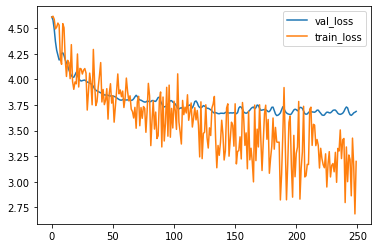

In [31]:
val_loss_change = []; loss_change = []
for i in range(0, len(scores)):
    val_loss_change.append(scores[i].history['val_loss'])
    loss_change.append(scores[i].history['loss'])

plt.plot(val_loss_change, label='val_loss')
plt.plot(loss_change, label='train_loss')
plt.legend(loc='upper right')
plt.show()

In [32]:
#loss and accuracy on validation set
age_model.evaluate(test_x, test_y, verbose=1)

32/32 [==============================] - 4s 98ms/step - loss: 3.6464 - accuracy: 0.0460


[3.646380662918091, 0.04600000008940697]

In [33]:
predictions = age_model.predict(test_x)

In [34]:
output_indexes = np.array([i for i in range(0, 101)])
apparent_predictions = np.sum(predictions * output_indexes, axis = 1)

In [35]:
mae = 0
for i in range(0 ,apparent_predictions.shape[0]):
    prediction = int(apparent_predictions[i])
    actual = np.argmax(test_y[i])
    
    abs_error = abs(prediction - actual)
    # actual_mean = actual_mean + actual
    
    mae = mae + abs_error
    
    mae = mae / apparent_predictions.shape[0]

print("mae: ",mae)
print("instances: ",apparent_predictions.shape[0])

mae:  0.004009012001005014
instances:  1000


In [36]:
#Testing model on a custom image

In [37]:

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

In [38]:
def loadImage(filepath):
    test_img = image.load_img(filepath, target_size=(224, 224))
    test_img = image.img_to_array(test_img)
    test_img = np.expand_dims(test_img, axis = 0)
    test_img /= 255
    return test_img

In [39]:
picture = "/content/drive/MyDrive/YOUNGER/face_old.jpeg"
#picture = "brando.jpg"
#picture = "katy-3.jpg"

prediction = age_model.predict(loadImage(picture))

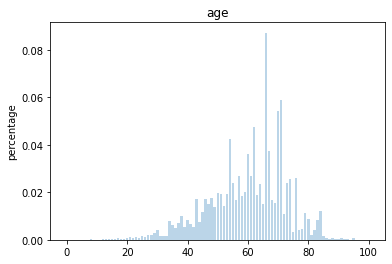

In [40]:

y_pos = np.arange(101)
plt.bar(y_pos, prediction[0], align='center', alpha=0.3)
plt.ylabel('percentage')
plt.title('age')
plt.show()

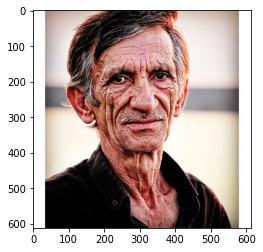

most dominant age class (not apparent age):  66
apparent age:  60


In [43]:
img = image.load_img(picture)#, target_size=(224, 224))
plt.imshow(img)
plt.show()

print("most dominant age class (not apparent age): ",np.argmax(prediction))

apparent_age = np.round(np.sum(prediction * output_indexes, axis = 1))
print("apparent age: ", int(apparent_age[0]))

**NOTE: The numpy array of the image data is 2.53 GB compressed. **

**This is a logical break point in the process as we have exported matrix_x, the array of pixel data and the related target vector, age.**

'matrix_x' is the array of the vectors of image pixel data.

'vector_y' is the array of ages.

---

## **IMAGE EXPLORATION**

---



---


# **SUMMARY**


---
Thus far, we have completed the Data Wrangling and Data Exploration phase of this project. We have downloaded, inspected and cleaned the metadata and the images dataset. We have looked at distributions and noticed some imbalanced classes which will need to be addressed. 

We have exported 2 objects that will persist to the next phase of the project: 'matrix_x' and 'vector_y'. 

'matrix_x' is an array of the grayscale pixel information extracted from our images. 

'vector_y' is an array of the ages of each observation, which is our target variable.

We also examined the concept of an 'average face' from the images in our dataset. More to come in the next phases, preprocessing & training.


# **REFERENCES**


1.   https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/ 
2.   https://data.vision.ee.ethz.ch/cvl/publications/papers/proceedings/eth_biwi_01229.pdf
3. https://sefiks.com/2019/02/13/apparent-age-and-gender-prediction-in-keras/ 
4. https://www.researchgate.net/publication/265125544_Face_Detection_without_Bells_and_Whistles
5. https://github.com/yu4u/age-gender-estimation

---